<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP_AE/MLP_AE_Bund10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 6.06 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 15:05:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Bund10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 13.8 MB/s 
     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 133 kB 56.7 MB/s 
     |████████████████████████████████| 170 kB 50.3 MB/s 
     |████████████████████████████████| 138 kB 45.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 62 kB 688 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(RepeatVector(window_len))
    # layer 7
    model.add(Dense(32, activation=config.activation))
    # layer 8
    model.add(Dense(64, activation=config.activation))
    # layer 9
    model.add(Dense(128, activation=config.activation))
    # layer 10
    model.add(Flatten())
    # layer 11
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: aaczrs4a
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP_AE/sweeps/aaczrs4a


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: e9oov3k1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
32/32 [==============================] - 16s 33ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1359 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1181
Epoch 2/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0385 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0980
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0365 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0738
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 6.9802e-04 - mean_squared_error: 6.9802e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0655
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_squared

epoch,30
loss,0.00069
mean_squared_error,0.00069
mean_absolute_error,0.0204
val_loss,0.00349
val_mean_squared_error,0.00349
val_mean_absolute_error,0.04548
_runtime,32
_timestamp,1627052774
_step,30
best_val_loss,0.00337


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▄▃▂▃▂▂▂▁▁▂▂▂▂▂▁▁▂▂▁▁▂▂▂▁▂▂
val_loss,█▆▃▃▃▃▂▂▃▂▃▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁
val_mean_squared_error,█▆▃▃▃▃▂▂▃▂▃▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁
val_mean_absolute_error,█▆▄▃▄▄▂▂▃▂▃▂▁▂▂▂▂▂▁▁▁▂▂▁▂▁▂▁▁▃▁
_runtime,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 9bpfu46v with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 51ms/step - loss: 0.0575 - mean_squared_error: 0.0575 - mean_absolute_error: 0.1718 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1260
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0648 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1191
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0528 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1045
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0420 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1134
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0051 - mean_squared_error:

epoch,40
loss,0.00215
mean_squared_error,0.00215
mean_absolute_error,0.0331
val_loss,0.01344
val_mean_squared_error,0.01344
val_mean_absolute_error,0.09198
_runtime,14
_timestamp,1627052807
_step,40
best_val_loss,0.00902


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▄▃▃▃▂▃▂▃▂▃▂▂▂▂▂▂▁▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▁
val_loss,▅▄▃▄▄█▃▃▂▅▄▂▅▃▂▂▄▂▂▂▂▃▃▂▁▁▂▁▁▂▁▂▁▁▂▁▁▂▃▂
val_mean_squared_error,▅▄▃▄▄█▃▃▂▅▄▂▅▃▂▂▄▂▂▂▂▃▃▂▁▁▂▁▁▂▁▂▁▁▂▁▁▂▃▂
val_mean_absolute_error,▆▅▄▅▅█▄▃▃▅▅▂▅▃▃▃▄▂▂▃▂▄▃▂▁▁▂▁▂▃▁▃▂▁▂▁▁▂▄▃
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 3lbjnfy3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 47ms/step - loss: 0.1418 - mean_squared_error: 0.1418 - mean_absolute_error: 0.3171 - val_loss: 0.1350 - val_mean_squared_error: 0.1350 - val_mean_absolute_error: 0.2987
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0779 - mean_squared_error: 0.0779 - mean_absolute_error: 0.2074 - val_loss: 0.0676 - val_mean_squared_error: 0.0676 - val_mean_absolute_error: 0.2028
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1424 - val_loss: 0.0513 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1856
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1513 - val_loss: 0.0502 - val_mean_squared_error: 0.0502 - val_mean_absolute_error: 0.1835
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0332 - mean_squared_err

epoch,99
loss,0.00156
mean_squared_error,0.00156
mean_absolute_error,0.03014
val_loss,0.01647
val_mean_squared_error,0.01647
val_mean_absolute_error,0.10581
_runtime,23
_timestamp,1627052850
_step,99
best_val_loss,0.01647


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ylr8no6k with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 91ms/step - loss: 5606.3324 - mean_squared_error: 5606.3324 - mean_absolute_error: 46.5007 - val_loss: 96.8290 - val_mean_squared_error: 96.8290 - val_mean_absolute_error: 9.6624
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 34.7477 - mean_squared_error: 34.7477 - mean_absolute_error: 3.8384 - val_loss: 1.2430 - val_mean_squared_error: 1.2430 - val_mean_absolute_error: 0.9551
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.5018 - mean_squared_error: 0.5018 - mean_absolute_error: 0.5861 - val_loss: 0.7317 - val_mean_squared_error: 0.7317 - val_mean_absolute_error: 0.6822
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.9333 - mean_squared_error: 0.9333 - mean_absolute_error: 0.6495 - val_loss: 49.9179 - val_mean_squared_error: 49.9179 - val_mean_absolute_error: 6.9937
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 188.5485 - mean_squared_

epoch,16
loss,9.72942
mean_squared_error,9.72942
mean_absolute_error,2.83748
val_loss,2.06709
val_mean_squared_error,2.06709
val_mean_absolute_error,1.35549
_runtime,8
_timestamp,1627052871
_step,16
best_val_loss,0.1426


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▂▁▁▁▅▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▂▁▁▁▅▁▁▁
mean_absolute_error,█▁▁▁▃▁▁▁▃▄▁▁▁▅▂▁▁
val_loss,▂▁▁▁▃▁▁▁▃▁▁▁▁█▁▁▁
val_mean_squared_error,▂▁▁▁▃▁▁▁▃▁▁▁▁█▁▁▁
val_mean_absolute_error,▃▁▁▃▄▁▁▂▅▁▁▂▃█▁▂▁
_runtime,▁▁▅▅▅▅▅▅▅▅███████
_timestamp,▁▁▅▅▅▅▅▅▅▅███████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: wmg62nx5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 3s 29ms/step - loss: 0.0650 - mean_squared_error: 0.0650 - mean_absolute_error: 0.1823 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1127
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0462 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1130
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0456 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1055
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0346 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0850
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0033 - mean_squared_

epoch,66
loss,0.00047
mean_squared_error,0.00047
mean_absolute_error,0.01672
val_loss,0.00657
val_mean_squared_error,0.00657
val_mean_absolute_error,0.06225
_runtime,32
_timestamp,1627052914
_step,66
best_val_loss,0.00558


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▂▂▁▂▂▁▂▂▁▂▁▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▄▄▃▃▃▄▂▂▂▆▃▂▁▂▂▂▂▂▂▁▁▁▁▃▁▂▁▂▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,██▄▄▃▃▃▄▂▂▂▆▃▂▁▂▂▂▂▂▂▁▁▁▁▃▁▂▁▂▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,██▄▅▃▃▄▄▃▂▂▅▃▂▂▂▂▂▂▂▂▁▁▁▂▃▁▂▁▂▂▁▂▁▁▂▁▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: x8f7yzsn with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 49ms/step - loss: 0.8298 - mean_squared_error: 0.8298 - mean_absolute_error: 0.6214 - val_loss: 0.5812 - val_mean_squared_error: 0.5812 - val_mean_absolute_error: 0.6989
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.1400 - mean_squared_error: 0.1400 - mean_absolute_error: 0.2813 - val_loss: 0.3002 - val_mean_squared_error: 0.3002 - val_mean_absolute_error: 0.5011
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0917 - mean_squared_error: 0.0917 - mean_absolute_error: 0.2355 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1248
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0524 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1033
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0037 - mean_squared_error

epoch,49
loss,0.00045
mean_squared_error,0.00045
mean_absolute_error,0.01602
val_loss,0.00435
val_mean_squared_error,0.00435
val_mean_absolute_error,0.05024
_runtime,20
_timestamp,1627052945
_step,49
best_val_loss,0.00419


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▇▂▂▁▁▃▄▂▁▁▁▁▁▁▁▁▁▁▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▇▂▂▁▁▃▄▂▁▁▁▁▁▁▁▁▁▁▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▇▄▃▁▁▄▅▄▁▁▁▁▁▁▁▁▁▁▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▁▁▁▅▂▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▂▁▁▁▅▂▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▃▁▁▁▆▄▂▁▁▁▁▁▁▁▁▁▁█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jdrc7nd4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 49ms/step - loss: 0.1120 - mean_squared_error: 0.1120 - mean_absolute_error: 0.2638 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1307
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0751 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1114
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0448 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1085
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0312 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1014
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_squared_

epoch,55
loss,0.00034
mean_squared_error,0.00034
mean_absolute_error,0.01351
val_loss,0.0043
val_mean_squared_error,0.0043
val_mean_absolute_error,0.04923
_runtime,18
_timestamp,1627052974
_step,55
best_val_loss,0.00411


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▄▃▃▃▃▂▂▂▂▂▁▁▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qynyfbv4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 27ms/step - loss: 0.3262 - mean_squared_error: 0.3262 - mean_absolute_error: 0.3657 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0976
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0422 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0712
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0360 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0663
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0282 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0549
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 9.7699e-04 - mean_square

epoch,29
loss,0.00041
mean_squared_error,0.00041
mean_absolute_error,0.01556
val_loss,0.0047
val_mean_squared_error,0.0047
val_mean_absolute_error,0.05311
_runtime,18
_timestamp,1627053002
_step,29
best_val_loss,0.00338


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▄▄▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▂▂▁▁▁▂
val_mean_squared_error,█▄▄▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▂▂▁▁▁▂
val_mean_absolute_error,█▅▄▂▃▂▃▃▃▂▂▂▂▂▃▂▁▂▂▁▁▂▁▁▂▃▁▁▁▂
_runtime,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ourudbqw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 95ms/step - loss: 0.0907 - mean_squared_error: 0.0907 - mean_absolute_error: 0.2400 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1365
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0841 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1572
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0640 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1308
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0444 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1157
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0024 - mean_squared_error: 0.0024 -

epoch,49
loss,0.00038
mean_squared_error,0.00038
mean_absolute_error,0.01456
val_loss,0.00471
val_mean_squared_error,0.00471
val_mean_absolute_error,0.05151
_runtime,14
_timestamp,1627053051
_step,49
best_val_loss,0.00444


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▅▄▄▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▆▅▄▄▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▆▅▅▅▄▄▃▃▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5q1q2jx2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 3s 28ms/step - loss: 164.6758 - mean_squared_error: 164.6758 - mean_absolute_error: 8.5112 - val_loss: 6.5546 - val_mean_squared_error: 6.5546 - val_mean_absolute_error: 2.3672
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 46.3740 - mean_squared_error: 46.3740 - mean_absolute_error: 4.9744 - val_loss: 9.2398 - val_mean_squared_error: 9.2398 - val_mean_absolute_error: 2.5835
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 27.8563 - mean_squared_error: 27.8563 - mean_absolute_error: 4.4582 - val_loss: 7.5231 - val_mean_squared_error: 7.5231 - val_mean_absolute_error: 2.7226
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 29.1130 - mean_squared_error: 29.1130 - mean_absolute_error: 4.4861 - val_loss: 2.9136 - val_mean_squared_error: 2.9136 - val_mean_absolute_error: 1.6763
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 16.2444 - me

epoch,34
loss,0.04095
mean_squared_error,0.04095
mean_absolute_error,0.15551
val_loss,0.05601
val_mean_squared_error,0.05601
val_mean_absolute_error,0.19551
_runtime,21
_timestamp,1627053084
_step,34
best_val_loss,0.05582


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▃▄▃▃▃▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▅▄▂▁▃▂▂█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▅▄▂▁▃▂▂█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▅▅▄▂▄▃▃█▂▁▃▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: d96tho88 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 149ms/step - loss: 0.0987 - mean_squared_error: 0.0987 - mean_absolute_error: 0.2562 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1560
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0870 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1611
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0938 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1299
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0666 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1316
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0068 - mean_squared_error: 0.0068 

epoch,49
loss,0.00317
mean_squared_error,0.00317
mean_absolute_error,0.04629
val_loss,0.01012
val_mean_squared_error,0.01012
val_mean_absolute_error,0.07645
_runtime,13
_timestamp,1627053109
_step,49
best_val_loss,0.00972


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▃▃▃▃▂▂▂▂▂▂▃▂▁▂▂▂▂▂▁▁▁▂▁▂▂▁▂▂▁▂▁▁▁▁▂▁
val_loss,▆▆▄▄▅█▇█▃▅▄▅▄▄▃▄▅▄▃▄▂▂▆▂▃▃▂▁▁▂▂▁▂▁▂▁▃▁▁▁
val_mean_squared_error,▆▆▄▄▅█▇█▃▅▄▅▄▄▃▄▅▄▃▄▂▂▆▂▃▃▂▁▁▂▂▁▂▁▂▁▃▁▁▁
val_mean_absolute_error,▇▇▅▅▆█▇█▄▆▅▅▅▅▃▅▅▄▄▅▂▃▆▂▃▃▂▂▁▂▂▁▂▁▂▁▃▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 51aj4t7a with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 3s 28ms/step - loss: 0.9499 - mean_squared_error: 0.9499 - mean_absolute_error: 0.5380 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1133
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.1286 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1175
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0395 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1049 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1232
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0559 - val_loss: 0.3852 - val_mean_squared_error: 0.3852 - val_mean_absolute_error: 0.5404
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0944 - mean_squared_er

epoch,32
loss,0.00821
mean_squared_error,0.00821
mean_absolute_error,0.05666
val_loss,0.01254
val_mean_squared_error,0.01254
val_mean_absolute_error,0.08668
_runtime,17
_timestamp,1627053138
_step,32
best_val_loss,0.00906


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▃▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▃▄▄▄▄▂▃▃▄▃▂▂▃▃▂▃▃▁▂▂▂▁▂▂▂▂▁▂▂▂
val_loss,▁▁▁█▂▁▂▁▇▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁█▂▁▂▁▇▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▂█▃▁▃▂█▁▂▁▂▂▂▂▁▂▁▁▁▁▁▁▃▁▂▁▁▂▁▂▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 4mtg8mi0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 3s 28ms/step - loss: 4.6036 - mean_squared_error: 4.6036 - mean_absolute_error: 0.8517 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1614
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_error: 0.1231 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1189
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1219 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1230
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1099 - val_loss: 0.0667 - val_mean_squared_error: 0.0667 - val_mean_absolute_error: 0.2081
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0231 - mean_squared_

epoch,61
loss,0.00218
mean_squared_error,0.00218
mean_absolute_error,0.03618
val_loss,0.02106
val_mean_squared_error,0.02106
val_mean_absolute_error,0.10232
_runtime,28
_timestamp,1627053185
_step,61
best_val_loss,0.00665


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃█▆▇▄▂▂▂▂▁▃▃▁▂▃▂▁▃▁▁▁▁▂▁▁▁▁▁▂▁▂▁▁▂▁▁▂▂▃
val_mean_squared_error,▅▃█▆▇▄▂▂▂▂▁▃▃▁▂▃▂▁▃▁▁▁▁▂▁▁▁▁▁▂▁▂▁▁▂▁▁▂▂▃
val_mean_absolute_error,▆▄█▆█▄▃▂▂▃▂▄▄▁▃▄▃▂▄▂▁▁▂▃▂▂▂▂▁▂▂▂▁▁▂▁▁▂▂▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: o9lf3b3g with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 52ms/step - loss: 0.0694 - mean_squared_error: 0.0694 - mean_absolute_error: 0.1916 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1183
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0585 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1102
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0601 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1265
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0683 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0939
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0025 - mean_squared_

epoch,31
loss,0.00223
mean_squared_error,0.00223
mean_absolute_error,0.03873
val_loss,0.01157
val_mean_squared_error,0.01157
val_mean_absolute_error,0.08398
_runtime,16
_timestamp,1627053213
_step,31
best_val_loss,0.00768


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▂▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
mean_squared_error,█▂▂▂▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
mean_absolute_error,█▄▃▃▃▃▂▃▁▃▃▁▃▂▂▂▂▁▂▂▂▁▂▁▂▁▂▁▂▃▁▂
val_loss,█▆█▄▃▇▃▃▃▂▃▃▆▂▃▂▂▁▂▃▁▁▁▁▁▂▂▁▅▁▂▃
val_mean_squared_error,█▆█▄▃▇▃▃▃▂▃▃▆▂▃▂▂▁▂▃▁▁▁▁▁▂▂▁▅▁▂▃
val_mean_absolute_error,▇▆█▄▄▇▃▃▃▃▃▃▆▃▄▂▃▁▂▃▂▁▂▁▁▃▂▂▅▂▃▃
_runtime,▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: qowcr5vy with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 94ms/step - loss: 21.6135 - mean_squared_error: 21.6135 - mean_absolute_error: 3.3861 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1054
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0568 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1008
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0777 - val_loss: 0.3330 - val_mean_squared_error: 0.3330 - val_mean_absolute_error: 0.5627
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 1.2839 - mean_squared_error: 1.2839 - mean_absolute_error: 0.9485 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1507
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0114 - mean_squared_error: 0.0114

epoch,11
loss,0.00539
mean_squared_error,0.00539
mean_absolute_error,0.05759
val_loss,0.03853
val_mean_squared_error,0.03853
val_mean_absolute_error,0.16598
_runtime,9
_timestamp,1627053233
_step,11
best_val_loss,0.01625


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▄▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▄▁
mean_absolute_error,█▁▁▃▁▁▂▁▁▁▄▁
val_loss,▁▁▃▁▁█▂▁▁▇▁▁
val_mean_squared_error,▁▁▃▁▁█▂▁▁▇▁▁
val_mean_absolute_error,▁▁▅▁▁█▃▁▁▇▂▂
_runtime,▁▁▁▁▁▁██████
_timestamp,▁▁▁▁▁▁██████
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: 5dcmk9lu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 90ms/step - loss: 0.4200 - mean_squared_error: 0.4200 - mean_absolute_error: 0.5017 - val_loss: 0.0527 - val_mean_squared_error: 0.0527 - val_mean_absolute_error: 0.1766
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0872 - mean_squared_error: 0.0872 - mean_absolute_error: 0.2457 - val_loss: 0.0810 - val_mean_squared_error: 0.0810 - val_mean_absolute_error: 0.2340
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1723 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1429
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0950 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1107
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0065 - mean_squared_error: 0.0

epoch,39
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.03042
val_loss,0.01461
val_mean_squared_error,0.01461
val_mean_absolute_error,0.09637
_runtime,13
_timestamp,1627053259
_step,39
best_val_loss,0.00647


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▅▄▂▁▁▁
mean_squared_error,█▃▂▁▁▁▁▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▅▄▂▁▁▁
mean_absolute_error,▇▅▃▂▂▁▁▃▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▆▅▃▂▁▁
val_loss,▂▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▁▁▁
val_mean_squared_error,▂▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▁▁▁
val_mean_absolute_error,▂▃▂▂▁▁▁▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▃▃▂▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tej0szz8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 4s 29ms/step - loss: 0.7646 - mean_squared_error: 0.7646 - mean_absolute_error: 0.6966 - val_loss: 0.2343 - val_mean_squared_error: 0.2343 - val_mean_absolute_error: 0.4288
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0579 - mean_squared_error: 0.0579 - mean_absolute_error: 0.1871 - val_loss: 0.1058 - val_mean_squared_error: 0.1058 - val_mean_absolute_error: 0.2815
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0538 - mean_squared_error: 0.0538 - mean_absolute_error: 0.1725 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1193
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0318 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0710
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0011 - mean_squared_

epoch,51
loss,0.00091
mean_squared_error,0.00091
mean_absolute_error,0.02341
val_loss,0.00575
val_mean_squared_error,0.00575
val_mean_absolute_error,0.05821
_runtime,31
_timestamp,1627053307
_step,51
best_val_loss,0.00352


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
mean_squared_error,▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
mean_absolute_error,▃▂▂▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
val_loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
val_mean_squared_error,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
val_mean_absolute_error,▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: i6qbfkij with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 92ms/step - loss: 0.1365 - mean_squared_error: 0.1365 - mean_absolute_error: 0.3110 - val_loss: 0.0418 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1666
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - mean_absolute_error: 0.1243 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1212
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0781 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1204
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0497 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1333
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028 -

epoch,49
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01481
val_loss,0.00583
val_mean_squared_error,0.00583
val_mean_absolute_error,0.05861
_runtime,15
_timestamp,1627053348
_step,49
best_val_loss,0.00544


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5g8lb5z9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 97ms/step - loss: 17.2723 - mean_squared_error: 17.2723 - mean_absolute_error: 3.1209 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1944
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1595 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1514
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1251 - val_loss: 0.1031 - val_mean_squared_error: 0.1031 - val_mean_absolute_error: 0.2761
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.4426 - mean_squared_error: 0.4426 - mean_absolute_error: 0.5351 - val_loss: 0.0530 - val_mean_squared_error: 0.0530 - val_mean_absolute_error: 0.1815
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0184 - mean_squared_error: 0.0184

epoch,44
loss,0.0124
mean_squared_error,0.0124
mean_absolute_error,0.07949
val_loss,0.02529
val_mean_squared_error,0.02529
val_mean_absolute_error,0.13262
_runtime,13
_timestamp,1627053374
_step,44
best_val_loss,0.0127


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁
mean_absolute_error,█▁▁▃▁▂▁▁▁▁▁▂▁▁▁▄▁▁▁▁▂▃▁▁▁▁▄▃▁▁▁▁▁▃▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,▁▁▁▁▁▂▁▂▁▁▂▁▁▁▄▁▁▁▁▁▂▁▁▁▁▁█▁▁▁▁▁▂▁▁▁▁▁▃▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zuwqjy0h with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 49ms/step - loss: 264.2194 - mean_squared_error: 264.2194 - mean_absolute_error: 11.0858 - val_loss: 37.6106 - val_mean_squared_error: 37.6106 - val_mean_absolute_error: 5.1466
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 36.9298 - mean_squared_error: 36.9298 - mean_absolute_error: 4.8988 - val_loss: 2.6649 - val_mean_squared_error: 2.6649 - val_mean_absolute_error: 1.2032
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 31.1644 - mean_squared_error: 31.1644 - mean_absolute_error: 4.6474 - val_loss: 15.2435 - val_mean_squared_error: 15.2435 - val_mean_absolute_error: 3.3685
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 9.7859 - mean_squared_error: 9.7859 - mean_absolute_error: 2.7335 - val_loss: 7.7429 - val_mean_squared_error: 7.7429 - val_mean_absolute_error: 2.5797
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 4.7305 - 

epoch,22
loss,0.25325
mean_squared_error,0.25325
mean_absolute_error,0.40378
val_loss,0.28565
val_mean_squared_error,0.28565
val_mean_absolute_error,0.48461
_runtime,12
_timestamp,1627053399
_step,22
best_val_loss,0.05494


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▄▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▄▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▅▄▁▁▃▂▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▃▃▃▃▃▅▅▅▅▆▆▆▆▆█████
_timestamp,▁▁▁▁▃▃▃▃▃▅▅▅▅▆▆▆▆▆█████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: qn5ijxk9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 92ms/step - loss: 0.2993 - mean_squared_error: 0.2993 - mean_absolute_error: 0.3471 - val_loss: 0.0656 - val_mean_squared_error: 0.0656 - val_mean_absolute_error: 0.2009
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1353 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - val_mean_absolute_error: 0.2899
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1381 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1284
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0867 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1379
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0138 - mean_squared_error: 0.0138 -

epoch,49
loss,0.00104
mean_squared_error,0.00104
mean_absolute_error,0.02544
val_loss,0.01014
val_mean_squared_error,0.01014
val_mean_absolute_error,0.07681
_runtime,17
_timestamp,1627053429
_step,49
best_val_loss,0.00958


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁
val_loss,▄█▂▂▂▂▂▁▂▂▂▂▁▁▃▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▂▂▂▂▂▁▂▂▂▂▁▁▃▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▃▃▂▂▃▂▃▃▂▂▂▂▄▁▁▃▂▂▁▃▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: h7e55u4q with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 90ms/step - loss: 376.5251 - mean_squared_error: 376.5251 - mean_absolute_error: 10.9749 - val_loss: 7.6543 - val_mean_squared_error: 7.6543 - val_mean_absolute_error: 2.7240
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 40.4331 - mean_squared_error: 40.4331 - mean_absolute_error: 5.4013 - val_loss: 73.2270 - val_mean_squared_error: 73.2270 - val_mean_absolute_error: 8.5426
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 39.8707 - mean_squared_error: 39.8707 - mean_absolute_error: 5.7232 - val_loss: 6.9008 - val_mean_squared_error: 6.9008 - val_mean_absolute_error: 2.6127
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 36.3567 - mean_squared_error: 36.3567 - mean_absolute_error: 4.4356 - val_loss: 287.6411 - val_mean_squared_error: 287.6411 - val_mean_absolute_error: 16.9538
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 113.6076 - mean_squ

epoch,16
loss,15.25274
mean_squared_error,15.25274
mean_absolute_error,3.48934
val_loss,41.47301
val_mean_squared_error,41.47301
val_mean_absolute_error,6.43212
_runtime,10
_timestamp,1627053452
_step,16
best_val_loss,1.20319


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
mean_squared_error,█▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▄▂▂▂▂▂▃▂▁▁▂▂▂
val_loss,▁▃▁█▃▁▁▂▁▂▃▁▂▁▁▁▂
val_mean_squared_error,▁▃▁█▃▁▁▂▁▂▃▁▂▁▁▁▂
val_mean_absolute_error,▂▄▂█▄▂▁▄▁▃▅▂▃▂▁▂▃
_runtime,▁▁▁▁▅▅▅▅▅▅▅▅█████
_timestamp,▁▁▁▁▅▅▅▅▅▅▅▅█████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: z6wnv95f with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 52ms/step - loss: 0.1454 - mean_squared_error: 0.1454 - mean_absolute_error: 0.3259 - val_loss: 0.1502 - val_mean_squared_error: 0.1502 - val_mean_absolute_error: 0.3204
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0827 - mean_squared_error: 0.0827 - mean_absolute_error: 0.2240 - val_loss: 0.0845 - val_mean_squared_error: 0.0845 - val_mean_absolute_error: 0.2262
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1451 - val_loss: 0.0527 - val_mean_squared_error: 0.0527 - val_mean_absolute_error: 0.1825
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1289 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1731
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0264 - mean_squared_error

epoch,49
loss,0.00221
mean_squared_error,0.00221
mean_absolute_error,0.03612
val_loss,0.02177
val_mean_squared_error,0.02177
val_mean_absolute_error,0.12431
_runtime,18
_timestamp,1627053483
_step,49
best_val_loss,0.02176


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eu920g5n with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 86ms/step - loss: 0.1407 - mean_squared_error: 0.1407 - mean_absolute_error: 0.3217 - val_loss: 0.1849 - val_mean_squared_error: 0.1849 - val_mean_absolute_error: 0.3633
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1125 - mean_squared_error: 0.1125 - mean_absolute_error: 0.2778 - val_loss: 0.1406 - val_mean_squared_error: 0.1406 - val_mean_absolute_error: 0.3064
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0860 - mean_squared_error: 0.0860 - mean_absolute_error: 0.2242 - val_loss: 0.1005 - val_mean_squared_error: 0.1005 - val_mean_absolute_error: 0.2484
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - mean_absolute_error: 0.1714 - val_loss: 0.0725 - val_mean_squared_error: 0.0725 - val_mean_absolute_error: 0.2091
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0424 - mean_squared_error: 0.0424 -

epoch,49
loss,0.00228
mean_squared_error,0.00228
mean_absolute_error,0.03778
val_loss,0.0195
val_mean_squared_error,0.0195
val_mean_absolute_error,0.11651
_runtime,14
_timestamp,1627053511
_step,49
best_val_loss,0.0195


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sdduha4t with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 52ms/step - loss: 116.6144 - mean_squared_error: 116.6144 - mean_absolute_error: 7.6316 - val_loss: 44.0197 - val_mean_squared_error: 44.0197 - val_mean_absolute_error: 6.4153
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 49.3034 - mean_squared_error: 49.3034 - mean_absolute_error: 5.4932 - val_loss: 40.4921 - val_mean_squared_error: 40.4921 - val_mean_absolute_error: 5.1569
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 37.5291 - mean_squared_error: 37.5291 - mean_absolute_error: 4.8396 - val_loss: 14.4847 - val_mean_squared_error: 14.4847 - val_mean_absolute_error: 3.7719
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 20.2797 - mean_squared_error: 20.2797 - mean_absolute_error: 3.8385 - val_loss: 8.9516 - val_mean_squared_error: 8.9516 - val_mean_absolute_error: 2.8560
Epoch 5/100
16/16 [==============================] - 0s 18ms/step - loss: 25.472

epoch,28
loss,1.06336
mean_squared_error,1.06336
mean_absolute_error,0.78522
val_loss,3.17461
val_mean_squared_error,3.17461
val_mean_absolute_error,1.77159
_runtime,16
_timestamp,1627053543
_step,28
best_val_loss,0.06664


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▃▃▂▃▂▂▃▂▃▃▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▃▂▂▃▂▃▃▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▅▃▄▄▃▄▄▃▂▂▃▂▂▁▁▁▂▁▂▁▁▁▁▁▁
val_loss,█▇▃▂▄▁▃▅▄▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▇▃▂▄▁▃▅▄▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▇▅▄▅▃▅▇▄▃▅▃▂▁▂▂▂▂▁▂▁▁▁▂▂▁▃▁▃
_runtime,▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: dnod64ha with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 50ms/step - loss: 0.0892 - mean_squared_error: 0.0892 - mean_absolute_error: 0.2215 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1348
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0712 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1283
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0799 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1403
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0671 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1157
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0073 - mean_squared_error

epoch,40
loss,0.00263
mean_squared_error,0.00263
mean_absolute_error,0.04087
val_loss,0.01145
val_mean_squared_error,0.01145
val_mean_absolute_error,0.08498
_runtime,17
_timestamp,1627053573
_step,40
best_val_loss,0.00872


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▅▄▃▃▄▃▃▃▂▃▃▂▂▂▂▃▂▂▁▂▂▂▂▂▁▂▂▂▁▁▂▁▂▂▁▂▁▂
val_loss,▇▆█▅▇▆▄█▇█▇▅▃▄█▃▃▂▆▂▆▃▄▁▃▂▂▂▁▁▁▄▂▂▂▂▂▂▃▂
val_mean_squared_error,▇▆█▅▇▆▄█▇█▇▅▃▄█▃▃▂▆▂▆▃▄▁▃▂▂▂▁▁▁▄▂▂▂▂▂▂▃▂
val_mean_absolute_error,▇▇█▅▆▆▄▇▇▇▆▅▃▄▇▃▃▂▅▂▆▃▄▁▃▂▂▂▁▁▁▄▁▂▂▃▂▃▃▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: lr735lj2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 92ms/step - loss: 12549.9157 - mean_squared_error: 12549.9157 - mean_absolute_error: 63.7025 - val_loss: 146.0887 - val_mean_squared_error: 146.0887 - val_mean_absolute_error: 11.0248
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 66.7014 - mean_squared_error: 66.7014 - mean_absolute_error: 5.6922 - val_loss: 2.8371 - val_mean_squared_error: 2.8371 - val_mean_absolute_error: 1.2954
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 1.9502 - mean_squared_error: 1.9502 - mean_absolute_error: 1.1543 - val_loss: 2.7497 - val_mean_squared_error: 2.7497 - val_mean_absolute_error: 1.3283
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 5.6631 - mean_squared_error: 5.6631 - mean_absolute_error: 1.7074 - val_loss: 92.5775 - val_mean_squared_error: 92.5775 - val_mean_absolute_error: 9.4125
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 40.1261 - mean

epoch,26
loss,155.9257
mean_squared_error,155.9257
mean_absolute_error,9.49668
val_loss,83.83073
val_mean_squared_error,83.83073
val_mean_absolute_error,9.10384
_runtime,13
_timestamp,1627053599
_step,26
best_val_loss,0.07164


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▃▂▁▁▁▁▄▂▁▁▂▁▁▂▃▁▁▂▂
val_loss,▂▁▁▂▁▂▁▁█▁▁▁▁▁█▁▁▁▂▁▁▃▁▁▁▂▂
val_mean_squared_error,▂▁▁▂▁▂▁▁█▁▁▁▁▁█▁▁▁▂▁▁▃▁▁▁▂▂
val_mean_absolute_error,▄▁▁▃▁▃▂▂█▁▁▃▁▂█▁▁▃▄▁▁▄▂▁▁▃▃
_runtime,▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆██
_timestamp,▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: ckxhp4xr with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 45ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - mean_absolute_error: 0.1226 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0833
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0317 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0732
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0263 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0726
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 9.5713e-04 - mean_squared_error: 9.5713e-04 - mean_absolute_error: 0.0242 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0687
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0011 - mean_

epoch,76
loss,0.00042
mean_squared_error,0.00042
mean_absolute_error,0.01553
val_loss,0.0055
val_mean_squared_error,0.0055
val_mean_absolute_error,0.05794
_runtime,23
_timestamp,1627053638
_step,76
best_val_loss,0.00474


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▃▃▂▃▃▃▂▂▂▃▂▂▂▁▃▂▂▂▂▁▂▁▁▂▂▁▁▂▁▂▁▁▁▂
val_mean_squared_error,█▆▄▄▃▃▃▃▂▃▃▃▂▂▂▃▂▂▂▁▃▂▂▂▂▁▂▁▁▂▂▁▁▂▁▂▁▁▁▂
val_mean_absolute_error,█▆▅▄▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▁▃▂▂▂▂▂▂▁▁▂▂▂▂▂▁▂▁▁▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: t45d0v78 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 4s 32ms/step - loss: 0.0518 - mean_squared_error: 0.0518 - mean_absolute_error: 0.1532 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1496
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0476 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0837
Epoch 3/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0387 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0931
Epoch 4/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0333 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0776
Epoch 5/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0012 - mean_squared_error

epoch,27
loss,0.00148
mean_squared_error,0.00148
mean_absolute_error,0.02957
val_loss,0.00923
val_mean_squared_error,0.00923
val_mean_absolute_error,0.07477
_runtime,22
_timestamp,1627053679
_step,27
best_val_loss,0.00606


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▂▁▁▂
val_loss,█▂▃▂▂▅▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂
val_mean_squared_error,█▂▃▂▂▅▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂
val_mean_absolute_error,█▃▄▂▂▆▂▂▃▂▂▁▂▁▁▂▁▁▁▁▁▁▂▁▂▁▂▂
_runtime,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: vz1605lm with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 49ms/step - loss: 0.6055 - mean_squared_error: 0.6055 - mean_absolute_error: 0.4820 - val_loss: 0.0545 - val_mean_squared_error: 0.0545 - val_mean_absolute_error: 0.2043
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - mean_absolute_error: 0.2059 - val_loss: 0.1126 - val_mean_squared_error: 0.1126 - val_mean_absolute_error: 0.2881
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0676 - mean_squared_error: 0.0676 - mean_absolute_error: 0.2068 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1170
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0668 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1001
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0039 - mean_squared_

epoch,46
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01613
val_loss,0.005
val_mean_squared_error,0.005
val_mean_absolute_error,0.05618
_runtime,19
_timestamp,1627053715
_step,46
best_val_loss,0.00356


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9kvu6wh5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 3s 31ms/step - loss: 0.0773 - mean_squared_error: 0.0773 - mean_absolute_error: 0.1908 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1180
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0390 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0971
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0464 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0921
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0403 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0917
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0020 - mean_squared_

epoch,55
loss,0.00053
mean_squared_error,0.00053
mean_absolute_error,0.01766
val_loss,0.0057
val_mean_squared_error,0.0057
val_mean_absolute_error,0.05794
_runtime,35
_timestamp,1627053764
_step,55
best_val_loss,0.00507


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▇▃▂▂▂▃▂▂▂▄▂▁▂▃▂▂▅▂▁▁▁▁▂▁▁▁▁▂▁▂▂▂▁▁
val_mean_squared_error,█▆▅▄▃▃▇▃▂▂▂▃▂▂▂▄▂▁▂▃▂▂▅▂▁▁▁▁▂▁▁▁▁▂▁▂▂▂▁▁
val_mean_absolute_error,█▆▅▄▄▃▇▃▃▂▂▃▂▂▃▄▂▂▃▃▂▂▅▂▁▁▁▁▂▁▁▁▁▂▁▂▂▂▂▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: fufp8sn0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 53ms/step - loss: 0.0745 - mean_squared_error: 0.0745 - mean_absolute_error: 0.1978 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1581
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0810 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1183
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0415 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1008
Epoch 4/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0464 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1009
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0049 - mean_squared_error

epoch,35
loss,0.00086
mean_squared_error,0.00086
mean_absolute_error,0.0229
val_loss,0.00801
val_mean_squared_error,0.00801
val_mean_absolute_error,0.06928
_runtime,19
_timestamp,1627053808
_step,35
best_val_loss,0.0074


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▃▃▂▂▂▂▂▂▂▃▂▂▂▂▁▃▁▁▂▁▁▂▂▃▁▁▁▂▁▁
val_loss,█▄▃▃▂▅▃▃▂▂▅▂▂▂▃▂▂▂▂▁▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▅▃▃▂▂▅▂▂▂▃▂▂▂▂▁▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▅▃▃▂▂▅▂▂▂▃▃▃▂▂▂▃▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mtym7egq with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 96ms/step - loss: 112.1662 - mean_squared_error: 112.1662 - mean_absolute_error: 8.0784 - val_loss: 4.8574 - val_mean_squared_error: 4.8574 - val_mean_absolute_error: 2.0892
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 67.7323 - mean_squared_error: 67.7323 - mean_absolute_error: 6.1752 - val_loss: 171.2967 - val_mean_squared_error: 171.2967 - val_mean_absolute_error: 12.8721
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 70.3226 - mean_squared_error: 70.3226 - mean_absolute_error: 6.9827 - val_loss: 29.5664 - val_mean_squared_error: 29.5664 - val_mean_absolute_error: 4.6272
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 29.8513 - mean_squared_error: 29.8513 - mean_absolute_error: 4.4075 - val_loss: 1.6671 - val_mean_squared_error: 1.6671 - val_mean_absolute_error: 1.1288
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 28.9697 - mean_squar

epoch,13
loss,23.82391
mean_squared_error,23.82391
mean_absolute_error,3.93648
val_loss,8.63057
val_mean_squared_error,8.63057
val_mean_absolute_error,2.6623
_runtime,11
_timestamp,1627053834
_step,13
best_val_loss,1.66711


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▄▃▁▂▂▂▁▁▁▂▁▂▁
mean_squared_error,█▄▃▁▂▂▂▁▁▁▂▁▂▁
mean_absolute_error,█▄▃▂▂▃▂▂▂▂▃▁▃▁
val_loss,▁█▂▁▃▁▂▁▂█▂▇▁▁
val_mean_squared_error,▁█▂▁▃▁▂▁▂█▂▇▁▁
val_mean_absolute_error,▂█▃▁▅▂▃▂▂█▃█▂▂
_runtime,▁▁▁▅▅▅▅▅▅█████
_timestamp,▁▁▁▅▅▅▅▅▅█████
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 3r4csfnq with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 90ms/step - loss: 4.2490 - mean_squared_error: 4.2490 - mean_absolute_error: 1.3048 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1016
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0465 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0984
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0441 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1198
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - mean_absolute_error: 0.1887 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1000
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0

epoch,16
loss,0.00959
mean_squared_error,0.00959
mean_absolute_error,0.07823
val_loss,0.0493
val_mean_squared_error,0.0493
val_mean_absolute_error,0.18266
_runtime,10
_timestamp,1627053859
_step,16
best_val_loss,0.01436


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁
mean_absolute_error,█▁▁▂▁▂▁▂▄▁▁▂▅▁▁▁▁
val_loss,▁▁▁▁▁▁▁█▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁█▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁█▁▁▁▃▁▁▁▁▁
_runtime,▁▁▁▁▁▅▅▅▅▅▅▅▅████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅▅▅████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: q70yrxdk with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 50ms/step - loss: 5385.0576 - mean_squared_error: 5385.0576 - mean_absolute_error: 45.9321 - val_loss: 1.7927 - val_mean_squared_error: 1.7927 - val_mean_absolute_error: 0.9120
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 1.8811 - mean_squared_error: 1.8811 - mean_absolute_error: 1.0513 - val_loss: 7.5164 - val_mean_squared_error: 7.5164 - val_mean_absolute_error: 2.6328
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 5.7318 - mean_squared_error: 5.7318 - mean_absolute_error: 2.0633 - val_loss: 61.9265 - val_mean_squared_error: 61.9265 - val_mean_absolute_error: 7.7620
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 69.2286 - mean_squared_error: 69.2286 - mean_absolute_error: 7.5500 - val_loss: 0.2187 - val_mean_squared_error: 0.2187 - val_mean_absolute_error: 0.4286
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 1677.7188 -

epoch,22
loss,16.88058
mean_squared_error,16.88058
mean_absolute_error,1.90591
val_loss,1.71814
val_mean_squared_error,1.71814
val_mean_absolute_error,1.20706
_runtime,13
_timestamp,1627053887
_step,22
best_val_loss,0.07835


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,▂▁▁▁▂▁▁▁▄▁▁▁▁▁▁▁▁▂▁▁▁█▁
mean_squared_error,▂▁▁▁▂▁▁▁▄▁▁▁▁▁▁▁▁▂▁▁▁█▁
mean_absolute_error,▇▁▁▂▄▂▂▁▇▁▂▂▂▁▃▁▁▄▂▂▁█▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▂▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,▁▁▂▁▁▂▃▁▂▁▁▂▁█▁▂▁▂▁▁▁▄▁
_runtime,▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆█████
_timestamp,▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆█████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: owp0y3k0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 88ms/step - loss: 26.6164 - mean_squared_error: 26.6164 - mean_absolute_error: 3.2591 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1505
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0886 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1305
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0875 - val_loss: 0.7266 - val_mean_squared_error: 0.7266 - val_mean_absolute_error: 0.8307
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 1.9585 - mean_squared_error: 1.9585 - mean_absolute_error: 1.1978 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1459
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0092 - mean_squared_error: 0.0092

epoch,17
loss,0.01797
mean_squared_error,0.01797
mean_absolute_error,0.10478
val_loss,0.02548
val_mean_squared_error,0.02548
val_mean_absolute_error,0.13182
_runtime,11
_timestamp,1627053918
_step,17
best_val_loss,0.01618


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▃▁
mean_squared_error,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▃▁
mean_absolute_error,█▁▁▃▁▂▁▁▂▅▁▁▁▁▁▂▅▁
val_loss,▁▁▂▁▁▁▁▁▅▁▁▁▁▁▁█▁▁
val_mean_squared_error,▁▁▂▁▁▁▁▁▅▁▁▁▁▁▁█▁▁
val_mean_absolute_error,▁▁▃▁▁▂▁▁▇▂▁▂▁▂▁█▁▁
_runtime,▁▁▁▁▁▅▅▅▅▅▅▅▅█████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅▅▅█████
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: 3w7vxz8n with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 3s 26ms/step - loss: 0.1251 - mean_squared_error: 0.1251 - mean_absolute_error: 0.2913 - val_loss: 0.0646 - val_mean_squared_error: 0.0646 - val_mean_absolute_error: 0.1987
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1457 - val_loss: 0.0494 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1814
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.1402 - val_loss: 0.0454 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1745
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0306 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1377 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1677
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0232 - mean_squared_erro

epoch,99
loss,0.00096
mean_squared_error,0.00096
mean_absolute_error,0.02345
val_loss,0.01046
val_mean_squared_error,0.01046
val_mean_absolute_error,0.08144
_runtime,44
_timestamp,1627053979
_step,99
best_val_loss,0.01046


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5j5kmxed with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 92ms/step - loss: 0.4234 - mean_squared_error: 0.4234 - mean_absolute_error: 0.4181 - val_loss: 0.0495 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1862
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1727 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1557
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0811 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1196
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0605 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1380
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036 -

epoch,49
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.01583
val_loss,0.00411
val_mean_squared_error,0.00411
val_mean_absolute_error,0.04886
_runtime,16
_timestamp,1627054009
_step,49
best_val_loss,0.0039


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▅▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▅▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▆▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lp3c3ree with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 28ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_err

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,11
_timestamp,1627054036
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▃▃▃▆▆▆███
_timestamp,▁▃▃▃▆▆▆███
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 0pgfusi4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 96ms/step - loss: 0.1473 - mean_squared_error: 0.1473 - mean_absolute_error: 0.3303 - val_loss: 0.1875 - val_mean_squared_error: 0.1875 - val_mean_absolute_error: 0.3660
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - mean_absolute_error: 0.2901 - val_loss: 0.1420 - val_mean_squared_error: 0.1420 - val_mean_absolute_error: 0.3084
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0845 - mean_squared_error: 0.0845 - mean_absolute_error: 0.2233 - val_loss: 0.1005 - val_mean_squared_error: 0.1005 - val_mean_absolute_error: 0.2488
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0563 - mean_squared_error: 0.0563 - mean_absolute_error: 0.1705 - val_loss: 0.0705 - val_mean_squared_error: 0.0705 - val_mean_absolute_error: 0.2066
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0346 - mean_squared_error: 0.0346 -

epoch,49
loss,0.00233
mean_squared_error,0.00233
mean_absolute_error,0.03757
val_loss,0.02132
val_mean_squared_error,0.02132
val_mean_absolute_error,0.11966
_runtime,16
_timestamp,1627054070
_step,49
best_val_loss,0.02132


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eg1lpv9f with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 80ms/step - loss: 0.0977 - mean_squared_error: 0.0977 - mean_absolute_error: 0.2521 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1422
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0787 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1295
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0465 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1255
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0407 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1228
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0022 - mean_squared_

epoch,62
loss,0.00034
mean_squared_error,0.00034
mean_absolute_error,0.01427
val_loss,0.00563
val_mean_squared_error,0.00563
val_mean_absolute_error,0.05672
_runtime,24
_timestamp,1627054112
_step,62
best_val_loss,0.00495


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▄▃▂▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 54bz9n7b with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 99ms/step - loss: 0.1194 - mean_squared_error: 0.1194 - mean_absolute_error: 0.2713 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1281
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0670 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1231
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0439 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1167
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0858 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1192
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0089 - mean_squared_error: 0.0089 -

epoch,49
loss,0.00337
mean_squared_error,0.00337
mean_absolute_error,0.0442
val_loss,0.01245
val_mean_squared_error,0.01245
val_mean_absolute_error,0.08886
_runtime,16
_timestamp,1627054143
_step,49
best_val_loss,0.0094


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▃▄▃▃▃▃▃▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂
val_loss,▃▃▃▃▄▅▄█▆▅▂▃▂▃▂▂▂▂▃▃▂▃▃▂▄▃▂▂▂▂▃▂▁▁▁▃▁▁▂▂
val_mean_squared_error,▃▃▃▃▄▅▄█▆▅▂▃▂▃▂▂▂▂▃▃▂▃▃▂▄▃▂▂▂▂▃▂▁▁▁▃▁▁▂▂
val_mean_absolute_error,▅▄▄▄▅▆▅█▇▅▃▃▃▃▃▃▃▃▃▄▃▄▃▃▅▄▂▃▃▃▃▂▁▁▁▃▂▁▂▂
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: p639kq8e with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 2s 26ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan 

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,12
_timestamp,1627054172
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▃▃▃▆▆▆█
_timestamp,▁▁▁▃▃▃▆▆▆█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: dnbyvbbh with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 48ms/step - loss: 0.1509 - mean_squared_error: 0.1509 - mean_absolute_error: 0.2623 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1936
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_me

epoch,10
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,12
_timestamp,1627054201
_step,10
best_val_loss,0.06274


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,▁
mean_squared_error,▁
mean_absolute_error,▁
val_loss,▁
val_mean_squared_error,▁
val_mean_absolute_error,▁
_runtime,▁▁▁▁▁▅▅▅▅▅█
_timestamp,▁▁▁▁▁▅▅▅▅▅█
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: g3i9c6wh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 50ms/step - loss: 0.1661 - mean_squared_error: 0.1661 - mean_absolute_error: 0.2859 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1378
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0744 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1263
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0516 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1303
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0375 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1159
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0018 - mean_squared_error

epoch,49
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.01589
val_loss,0.0043
val_mean_squared_error,0.0043
val_mean_absolute_error,0.0506
_runtime,21
_timestamp,1627054240
_step,49
best_val_loss,0.0037


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_loss,██▇▆▅▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,██▇▆▅▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▅▄▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▂▂▁▂▂▁▁▂▁▁▁▁▃▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rrnu4g1k with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 93ms/step - loss: 204.9795 - mean_squared_error: 204.9795 - mean_absolute_error: 9.8174 - val_loss: 217.3178 - val_mean_squared_error: 217.3178 - val_mean_absolute_error: 14.7003
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 92.4727 - mean_squared_error: 92.4727 - mean_absolute_error: 8.3100 - val_loss: 2.5035 - val_mean_squared_error: 2.5035 - val_mean_absolute_error: 1.3676
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 11.0938 - mean_squared_error: 11.0938 - mean_absolute_error: 2.8586 - val_loss: 1.2949 - val_mean_squared_error: 1.2949 - val_mean_absolute_error: 0.9722
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 9.2419 - mean_squared_error: 9.2419 - mean_absolute_error: 2.1474 - val_loss: 8.8855 - val_mean_squared_error: 8.8855 - val_mean_absolute_error: 2.9537
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 12.8152 - mean_squared_e

epoch,34
loss,0.05396
mean_squared_error,0.05396
mean_absolute_error,0.17962
val_loss,0.05548
val_mean_squared_error,0.05548
val_mean_absolute_error,0.19795
_runtime,14
_timestamp,1627054278
_step,34
best_val_loss,0.05547


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▃▃▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▂▄▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆███████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆███████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ax8qd4r8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 3s 29ms/step - loss: 0.0782 - mean_squared_error: 0.0782 - mean_absolute_error: 0.2201 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1530
Epoch 2/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0522 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1259
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0364 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1085
Epoch 4/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0295 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0867
Epoch 5/50
32/32 [==============================] - 0s 11ms/step - loss: 9.3906e-04 - mean_squared_e

epoch,49
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01515
val_loss,0.0051
val_mean_squared_error,0.0051
val_mean_absolute_error,0.0552
_runtime,29
_timestamp,1627054322
_step,49
best_val_loss,0.00437


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▃▃▂▃▂▂▂▂▂▁▁▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ipopu0zb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 28ms/step - loss: 0.1317 - mean_squared_error: 0.1317 - mean_absolute_error: 0.3000 - val_loss: 0.0841 - val_mean_squared_error: 0.0841 - val_mean_absolute_error: 0.2247
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1567 - val_loss: 0.0529 - val_mean_squared_error: 0.0529 - val_mean_absolute_error: 0.1876
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1488 - val_loss: 0.0513 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1827
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - mean_absolute_error: 0.1333 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1738
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0263 - mean_squared_

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'relu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(RepeatVector(window_len))
# layer 7
model.add(Dense(32, activation=best_config['activation']))
# layer 8
model.add(Dense(64, activation=best_config['activation']))
# layer 9
model.add(Dense(128, activation=best_config['activation']))
# layer 10
model.add(Flatten())
# layer 11
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  88769


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 960)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            3

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
40/40 [==============================] - 2s 6ms/step - loss: 0.0977
Epoch 2/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 3/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 4/50
40/40 [==============================] - 0s 6ms/step - loss: 8.9002e-04
Epoch 5/50
40/40 [==============================] - 0s 7ms/step - loss: 6.8623e-04
Epoch 6/50
40/40 [==============================] - 0s 6ms/step - loss: 8.9099e-04
Epoch 7/50
40/40 [==============================] - 0s 6ms/step - loss: 7.9467e-04
Epoch 8/50
40/40 [==============================] - 0s 6ms/step - loss: 9.0731e-04
Epoch 9/50
40/40 [==============================] - 0s 6ms/step - loss: 6.3224e-04
Epoch 10/50
40/40 [==============================] - 0s 6ms/step - loss: 5.3909e-04
Epoch 11/50
40/40 [==============================] - 0s 6ms/step - loss: 5.2462e-04
Epoch 12/50
40/40 [==============================] - 0s 6ms/step - loss: 8.1486e-04
Epoch 13/50
4

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

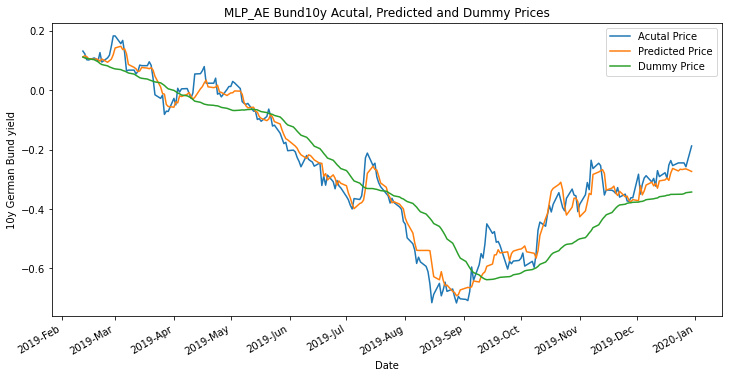

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

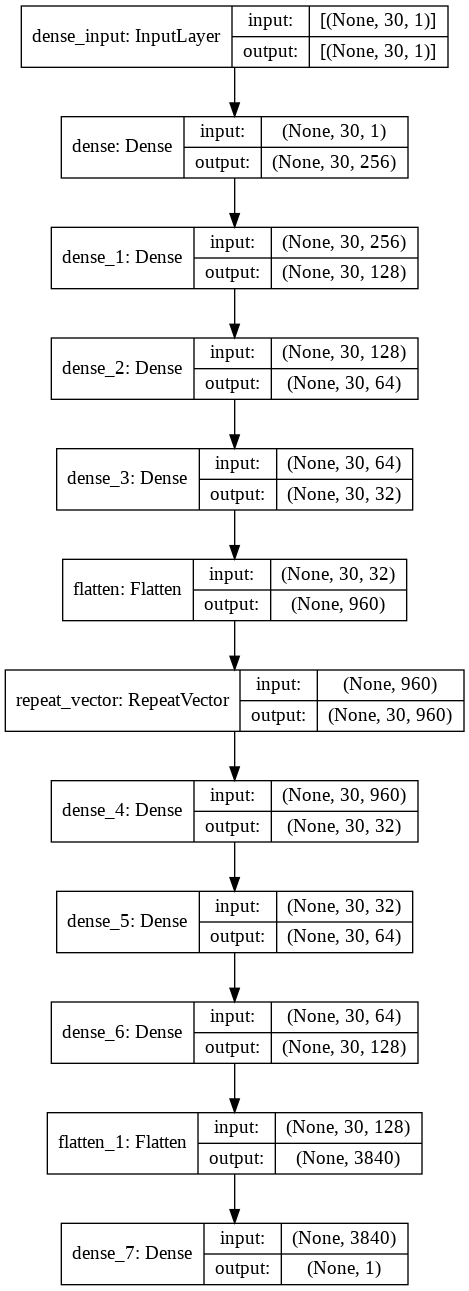

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.004965709538333406
RMSE:  0.07046779078652464
MAE:  0.05892175282156436
Dummy MSE:  0.01192499274023522
Dummy RMSE:  0.10920161509902324
Dummy MAE:  0.0887186459104488


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_AE_Bund10y/assets
